In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.layers import SimpleRNN # new! 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

### Setting hyperparameters

In [2]:
# output directory name:
output_dir = "model_output//"

# training:
epochs = 10
batch_size = 128

# vector space embedding:
n_dims = 64
n_unique_words = 5000   # taking just the top 5000 most commn words
max_review_length = 100    # maximum length a review can go upto (lowered due to vanishing gradient over time)
pad_type = trunc_type = 'pre'   # where to pad and truncate the sentence from
drop_embed = 0.2   # dropout after embedding layer

# convolution layer architecture
n_conv = 256
k_conv = 3 

# rnn layer architecture:
n_rnn = 256
drop_rnn = 0.2

### Load Data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\mukul\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\mukul\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is 

### Preprocessing the Data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

## Designing the NN Architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dims, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(SimpleRNN(n_rnn, dropout=drop_rnn))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 64)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               82176     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 402,433
Trainable params: 402,433
Non-trainable params: 0
_________________________________________________________________


### Configuring the model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"rnn_sentiment_classifier_nlp.h5", save_best_only=True)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Training

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/10
196/196 [==============================] - 26s 132ms/step - loss: 0.7035 - accuracy: 0.5046 - val_loss: 0.6944 - val_accuracy: 0.5097
Epoch 2/10
196/196 [==============================] - 26s 131ms/step - loss: 0.7028 - accuracy: 0.5127 - val_loss: 0.6946 - val_accuracy: 0.5184
Epoch 3/10
196/196 [==============================] - 27s 140ms/step - loss: 0.6946 - accuracy: 0.5122 - val_loss: 0.6913 - val_accuracy: 0.5123
Epoch 4/10
196/196 [==============================] - 28s 143ms/step - loss: 0.6883 - accuracy: 0.5330 - val_loss: 0.6889 - val_accuracy: 0.5168
Epoch 5/10
196/196 [==============================] - 28s 143ms/step - loss: 0.6745 - accuracy: 0.5674 - val_loss: 0.6611 - val_accuracy: 0.5864
Epoch 6/10
196/196 [==============================] - 29s 147ms/step - loss: 0.6247 - accuracy: 0.6385 - val_loss: 0.5762 - val_accuracy: 0.6968
Epoch 7/10
196/196 [==============================] - 30s 155ms/step - loss: 0.5830 - accuracy: 0.6970 - val_loss: 0.7185 - val_ac

### Evaluation

In [10]:
model.load_weights(output_dir+"rnn_sentiment_classifier_nlp.h5")

In [11]:
y_hat = model.predict(x_valid)

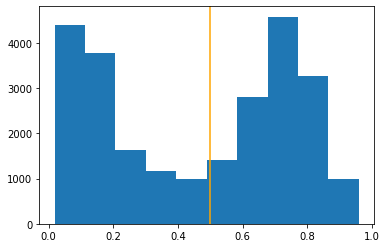

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')
plt.savefig('hist_plot.png')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'81.72'